# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/deeprl/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64", seed=1)
env.reset()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


{'TennisBrain': <unityagents.brain.BrainInfo at 0x7f0f0e7ab898>}

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.81114531 -1.5
 -0.          0.          6.00063038  5.99607611 -0.          0.        ]


### 4. Create Critic and Actor models

In [5]:

from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import torch.optim as optim

def hidden_init(layer):
    # source: The other layers were initialized from uniform distributions
    # [− 1/sqrt(f) , 1/sqrt(f) ] where f is the fan-in of the layer
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
    
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256,
                 fc2_units=128):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fc1_units: int. Number of nodes in first hidden layer
        :param fc2_units: int. Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # source: The low-dimensional networks had 2 hidden layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        # source: The final layer weights and biases of the actor and were
        # initialized from a uniform distribution [−3 × 10−3, 3 × 10−3]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        # source: used the rectified non-linearity for all hidden layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # source The final output layer of the actor was a tanh layer,
        # to bound the actions
        return torch.tanh(self.fc3(x))
        
        
        
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, nb_agents, seed,
                 fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fcs1_units: int. Nb of nodes in the first hiddenlayer
        :param fc2_units: int. Nb of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size)*nb_agents, fcs1_units)#*nb_agents
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        # source: The final layer weights and biases of the critic were
        # initialized from a uniform distribution [3 × 10−4, 3 × 10−4]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        xs = torch.cat((state, action.float()), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 5. Create Noise Generator

In [6]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x)
        # dx += self.sigma * np.random.rand(*self.size)  # Uniform disribution
        dx += self.sigma * np.random.randn(self.size)  # normal distribution
        # dx += self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### 6. Create Replay Buffer

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 7. Create DDPG single agent

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 0.0001        # learning rate of the actor
LR_CRITIC = 0.001        # learning rate of the critic
WEIGHT_DECAY = 0.0001        # L2 weight decay
NOISE_DECAY = 0.99
sharedBuffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

class DDPGAgent(object):
    '''
    Implementation of a DDPG agent that interacts with and learns from the
    environment
    '''

    def __init__(self, state_size, action_size, rand_seed,nb_agents):
        '''Initialize an MetaAgent object.
        :param state_size: int. dimension of each state
        :param action_size: int. dimension of each action
        
        :param rand_seed: int. random seed
        
        '''
        self.state_size = state_size
        self.action_size = action_size

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, rand_seed).to(device)
        self.actor_target = Actor(state_size, action_size, rand_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, nb_agents, rand_seed).to(device)
        self.critic_target = Critic(state_size, action_size, nb_agents, rand_seed).to(device)
        # NOTE: the decay corresponds to L2 regularization
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)  # , weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, rand_seed)
        
        
   
    
    def step(self):
        if len(sharedBuffer) > BATCH_SIZE:
            experiences = sharedBuffer.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        '''Returns actions for given states as per current policy.
        :param states: array_like. current states
        :param add_noise: Boolean. If should add noise to the action
        '''
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        # source: Select action at = μ(st|θμ) + Nt according to the current
        # policy and exploration noise
        if add_noise:
            actions += self.noise.sample()
            
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        '''
        Update policy and value params using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        :param experiences: Tuple[torch.Tensor]. tuple of (s, a, r, s', done)
        :param gamma: float. discount factor
        '''
        states_list, actions_list, rewards, next_states_list, dones = experiences
                    
        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = [self.actor_target(states) for states in states_list]        
        next_actions_tensor = torch.cat(next_actions, dim=1).to(device)        
        Q_targets_next = self.critic_target(next_states_tensor, next_actions_tensor)        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        # Compute critic loss
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # take the current states and predict actions
        actions_pred = [self.actor_local(states) for states in states_list]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        # -1 * (maximize) Q value for the current prediction
        actor_loss = -self.critic_local(states_tensor, actions_pred_tensor).mean()        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        #torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 8. Create Multi-agent DDPG

In [9]:
class MADDPG(object):
    '''
    Implementation of a MADDPG agent that interacts with and learns from the
    environment
    '''

    def __init__(self, state_size, action_size, nb_agents, random_seed):
        '''Initialize an MultiAgent object.
        :param state_size: int. dimension of each state
        :param action_size: int. dimension of each action
        :param nb_agents: int. number of agents to use
        :param rand_seed: int. random seed
        '''
        self.nb_agents = nb_agents
        self.action_size = action_size
        self.agents = [DDPGAgent(state_size,action_size,random_seed,nb_agents) for x in range(nb_agents)]# creating agents

    def step(self, states, actions, rewards, next_states, dones):
        sharedBuffer.add(states, actions, rewards, next_states, dones)
        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def reset(self):
        for agent in self.agents:
            agent.reset()

    def __len__(self):
        return self.nb_agents

    def __getitem__(self, key):
        return self.agents[key]
    
    def save_weights(self):
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))

### 9. Train Agent

In [11]:
agent = MADDPG(state_size=state_size, action_size=action_size,nb_agents = num_agents, random_seed=0)

def maddpg(n_episodes=5000, max_t=1000, print_every=100):
    scores_window = deque(maxlen=print_every)
    scores = []
    scores_avg = []
    scores_std = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] #reset the environment with every episode
        states = env_info.vector_observations 
        agent.reset()
        score = np.zeros(len(agent))
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name] #Taking one step
            next_states = env_info.vector_observations   
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        scores_avg.append(np.mean(scores_window))
        scores_std.append(np.std(scores_window))
        print('\rEpisode {}\tAverage Score: {:.3f} \t Max Score: {:.3f}'.format(i_episode, np.mean(scores_window),np.max(scores_window)), end="")
        """ for i in range(len(agent)):
            str_actor = ('checkpoint_actor_maddpg_%i.pth')%(i)
            str_critic = ('checkpoint_critic_maddpg_%i.pth')%(i)
            torch.save(agent[i].actor_local.state_dict(), str_actor)
            torch.save(agent[i].critic_local.state_dict(), str_critic)
        """    
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f} '.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=0.5:
            agent.save_weights()
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.3f} '.format(i_episode, np.mean(scores_window)))
            break
            
    return scores

scores = maddpg()

Episode 100	Average Score: 0.007 	 Max Score: 0.100
Episode 200	Average Score: 0.003 	 Max Score: 0.100
Episode 300	Average Score: 0.000 	 Max Score: 0.000
Episode 400	Average Score: 0.007 	 Max Score: 0.100
Episode 500	Average Score: 0.012 	 Max Score: 0.190
Episode 600	Average Score: 0.013 	 Max Score: 0.100
Episode 700	Average Score: 0.011 	 Max Score: 0.100
Episode 800	Average Score: 0.001 	 Max Score: 0.090
Episode 900	Average Score: 0.008 	 Max Score: 0.100
Episode 1000	Average Score: 0.049 	 Max Score: 0.100
Episode 1100	Average Score: 0.055 	 Max Score: 0.100
Episode 1200	Average Score: 0.077 	 Max Score: 0.200
Episode 1300	Average Score: 0.088 	 Max Score: 0.200
Episode 1400	Average Score: 0.106 	 Max Score: 0.300
Episode 1500	Average Score: 0.103 	 Max Score: 0.400
Episode 1600	Average Score: 0.128 	 Max Score: 0.400
Episode 1700	Average Score: 0.168 	 Max Score: 0.900
Episode 1800	Average Score: 0.258 	 Max Score: 1.400
Episode 1900	Average Score: 0.323 	 Max Score: 1.400
Ep

### 10. Plot Results

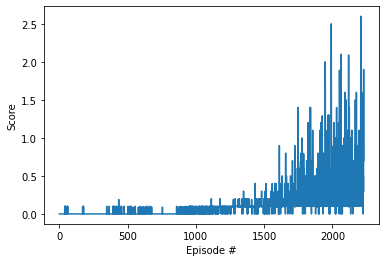

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()



### 11. Watch smart agents

In [12]:
env_info = env.reset(train_mode=False)[brain_name]
agent = MADDPG(state_size=state_size, action_size=action_size,nb_agents = num_agents, random_seed=0)
for i in range(len(agent)):
    agent[i].actor_local.load_state_dict(torch.load('agent{}_checkpoint_actor.pth'.format(i+1)))
    agent[i].critic_local.load_state_dict(torch.load('agent{}_checkpoint_critic.pth'.format(i+1)))

states = env_info.vector_observations            # get the current state
scores = np.zeros(len(agent))                                          # initialize the score
for i in range(1000):
    actions = agent.act(states)                # select an action
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations   # get the next state
    rewards = env_info.rewards                  # get the reward
    dones = env_info.local_done                 # see if episode has finished
    scores += rewards                                # update the score
    states = next_states                             # roll over the state to next time step
    
    
print("Average Score: {}".format(np.mean(scores))) 

Average Score: 2.3800000362098217
